In [2]:
import torch
import torch.nn as nn
from skimage import io
import numpy as np 
import albumentations as A
import matplotlib.pyplot as plt
import timm

In [3]:
img_path = "./sample_images/mug.jpeg"
model_reg_path = "timm/vit_giant_patch14_reg4_dinov2.lvd142m"
model_no_reg_path = "timm/vit_giant_patch14_dinov2.lvd142m"
img_size = 1024

In [6]:
def get_image(img_path,size=img_size):
    def get_image(img_path, size=img_size):
        """
        Loads an image from the specified path, normalizes it, and resizes it.

        Args:
            img_path (str): The file path to the image.
            size (int, optional): The size to which the image will be resized. Defaults to img_size.

        Returns:
            tuple: A tuple containing:
                - torch.Tensor: The processed image tensor with shape (1, 3, size, size).
                - numpy.ndarray: The normalized image array.
                - numpy.ndarray: The original image array.
        """
    img = io.imread(img_path)
    org_img = img.copy()

    img = A.Normalize()(image=img)['image']
    norm_img = img.copy()

    img = np.transpose(img, (2, 0, 1)) # HWC to CHW
    img = np.expand_dims(img, axis=0) # add batch dimension

    img = torch.tensor(img, dtype=torch.float32)
    img = nn.Upsample(size=(size, size),mode='bilinear')(img)

    return img, norm_img, org_img

outputs = {}
def get_outputs(name):
    """
    Returns a hook function that captures the output of a specific layer in a model.
    Args:
        name (str): The name to associate with the captured output.
    Returns:
        function: A hook function that can be registered to a model layer. When the layer is executed,
                  the hook function will store the output in the `outputs` dictionary under the given name.
    """
    def hook(model, input, output):
        outputs[name] = output.detach()
        
    return hook

In [4]:
model_reg = timm.create_model(model_reg_path, pretrained=True,img_size=img_size)
model_reg = model_reg.cuda()

In [ ]:
# Get the processed image, normalized image, and original image
img, norm_img, org_img = get_image(img_path)

# Get the scale factor for the attention mechanism from the last block of the model
scale = model_reg.blocks[-1].attn.scale

# Register hooks to capture the outputs of the q_norm and k_norm layers in the last block of the model
model_reg.blocks[-1].attn.q_norm.register_forward_hook(get_outputs('q_norm'))
model_reg.blocks[-1].attn.k_norm.register_forward_hook(get_outputs('k_norm'))

# Register a hook to capture the features output from the last block of the model
model_reg.blocks[-1].register_forward_hook(get_outputs('features'))

In [6]:
# Set the model to evaluation mode
model_reg.eval()

# Disable gradient calculation for efficiency
with torch.no_grad():
    # Perform a forward pass with the processed image
    out = model_reg(img.cuda())

# Compute the attention matrix using the captured q_norm and k_norm outputs
outputs["attention"] = (outputs["q_norm"] @ outputs["k_norm"].transpose(-2, -1)) * scale

# Apply softmax to the attention matrix to get the attention weights
outputs["attention"] = outputs["attention"].softmax(dim=-1)

/home/vip/anaconda3/envs/env_torch/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


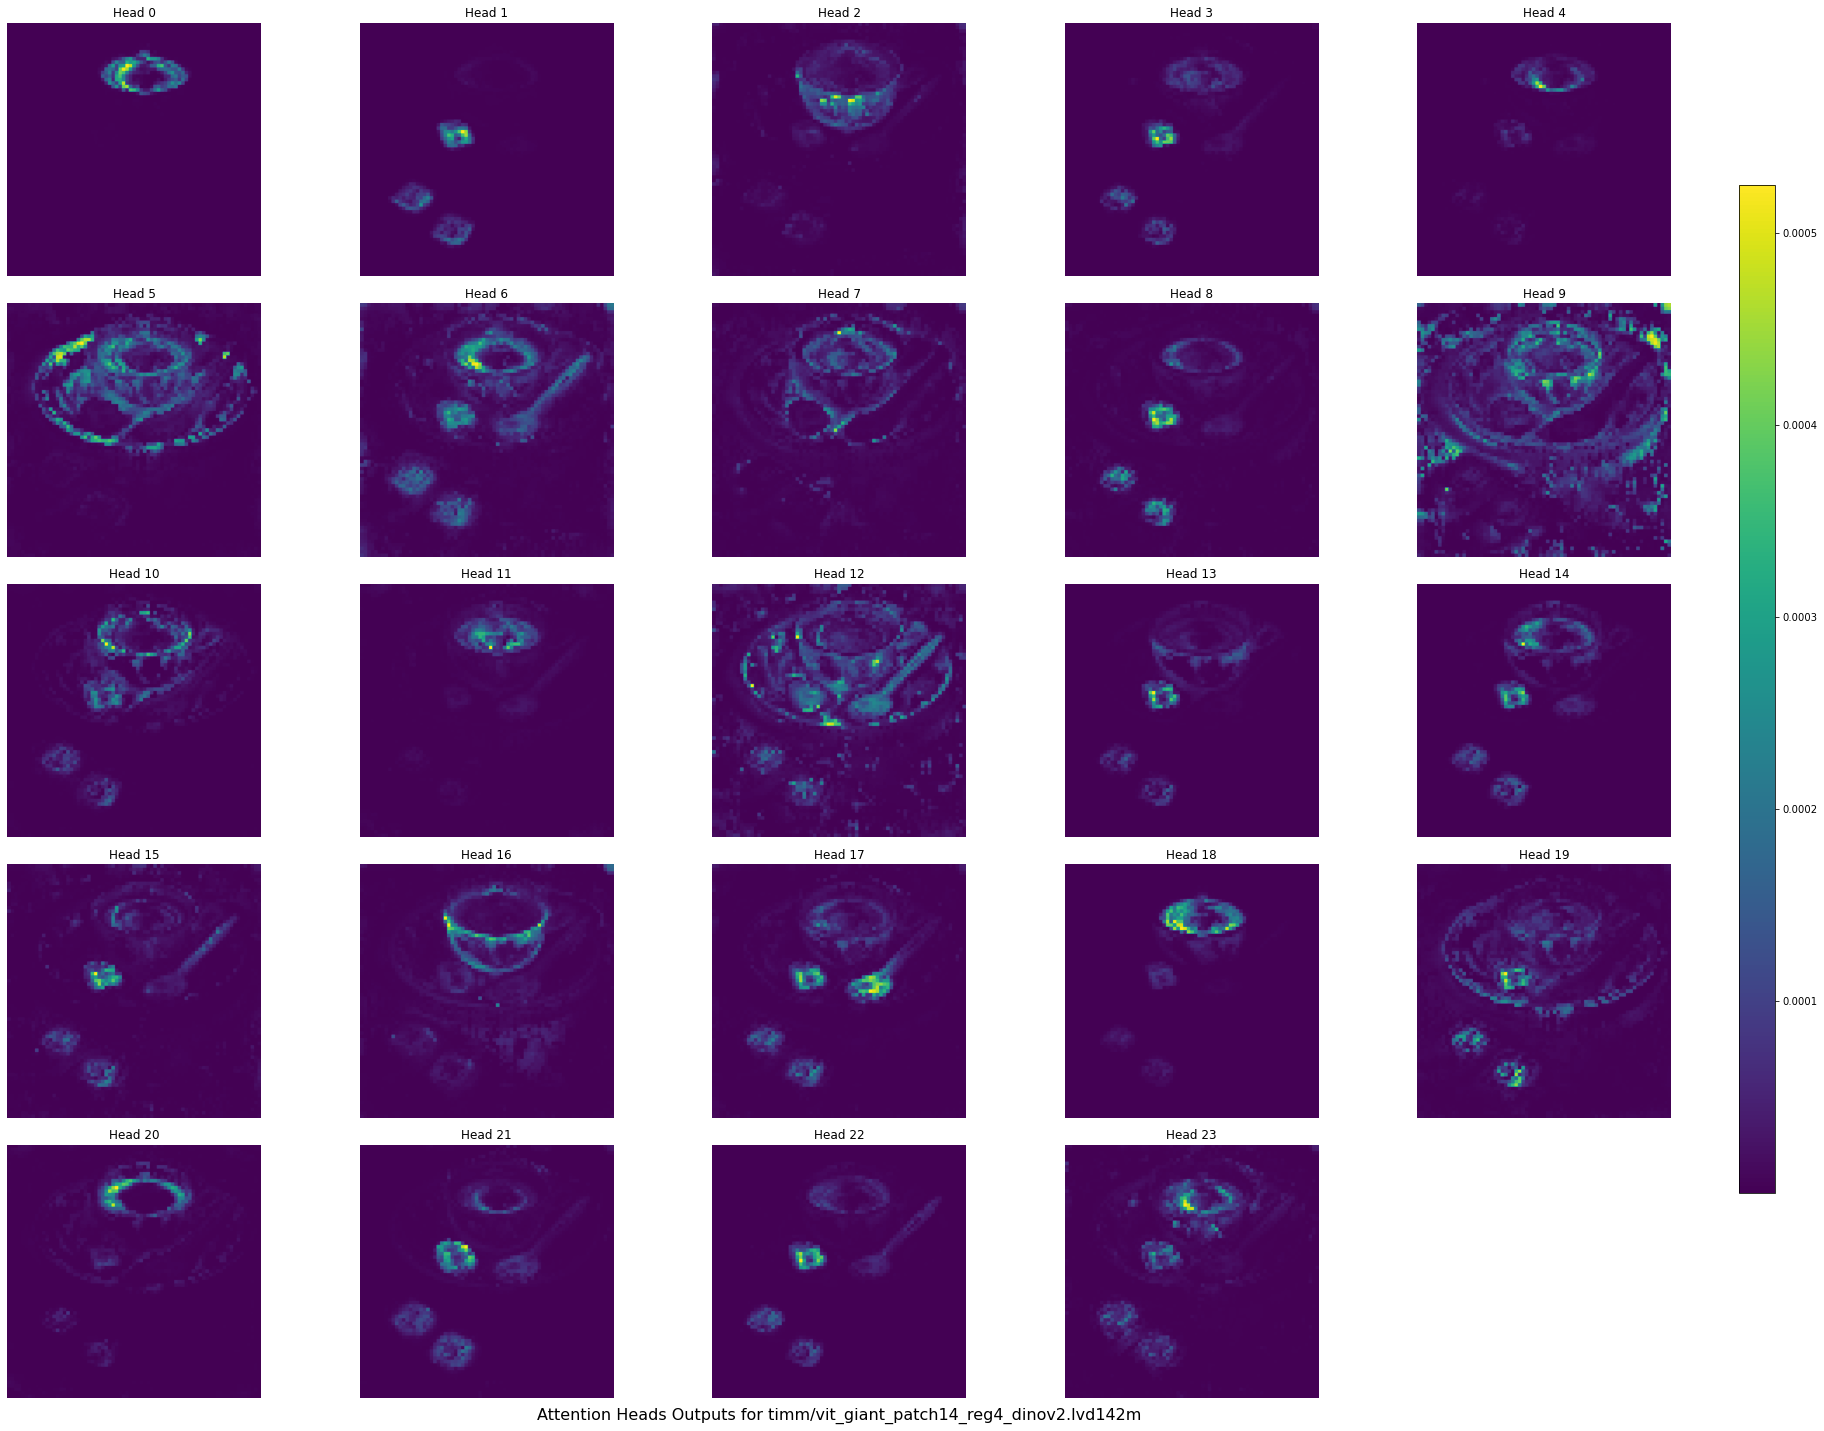

In [7]:
b, num_heads, num_patches_1, num_patches_1 = outputs["attention"].shape
map_size = int(np.sqrt(num_patches_1 - 5))

num_plots = num_heads
cols = int(np.ceil(np.sqrt(num_plots)))
rows = int(np.ceil(num_plots / cols))

fig, axes = plt.subplots(rows, cols, figsize=(25, 20))
axes = axes.flatten()

for i in range(num_plots):
    attention_head = i
    attention_map = outputs["attention"][:, attention_head, 0, 5:]
    attention_map = attention_map.view(1, 1, map_size, map_size)
    attention_map = nn.Upsample(size=(img_size, img_size))(attention_map)
    attention_map = attention_map[0, 0, :, :].detach().cpu().numpy()

    im = axes[i].imshow(attention_map)
    axes[i].set_title(f'Head {attention_head}')
    axes[i].axis('off')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig.suptitle('Attention Heads Outputs for '+model_reg_path, y=0.001, fontsize=16)

plt.tight_layout()
plt.show()

In [8]:
torch.cuda.empty_cache()

In [4]:
model = timm.create_model(model_no_reg_path, pretrained=True,img_size=img_size)
model = model.cuda()

In [7]:
# Get the processed image, normalized image, and original image
img, norm_img, org_img = get_image(img_path)

# Get the scale factor for the attention mechanism from the last block of the model
scale = model.blocks[-1].attn.scale

# Register hooks to capture the outputs of the q_norm and k_norm layers in the last block of the model
model.blocks[-1].attn.q_norm.register_forward_hook(get_outputs('q_norm'))
model.blocks[-1].attn.k_norm.register_forward_hook(get_outputs('k_norm'))

# Register a hook to capture the features output from the last block of the model
model.blocks[-1].register_forward_hook(get_outputs('features'))

In [8]:
model.eval()
with torch.no_grad():
    out = model(img.cuda())

outputs["attention"] = (outputs["q_norm"] @ outputs["k_norm"].transpose(-2, -1)) * scale
outputs["attention"] = outputs["attention"].softmax(dim=-1)

/home/vip/anaconda3/envs/env_torch/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


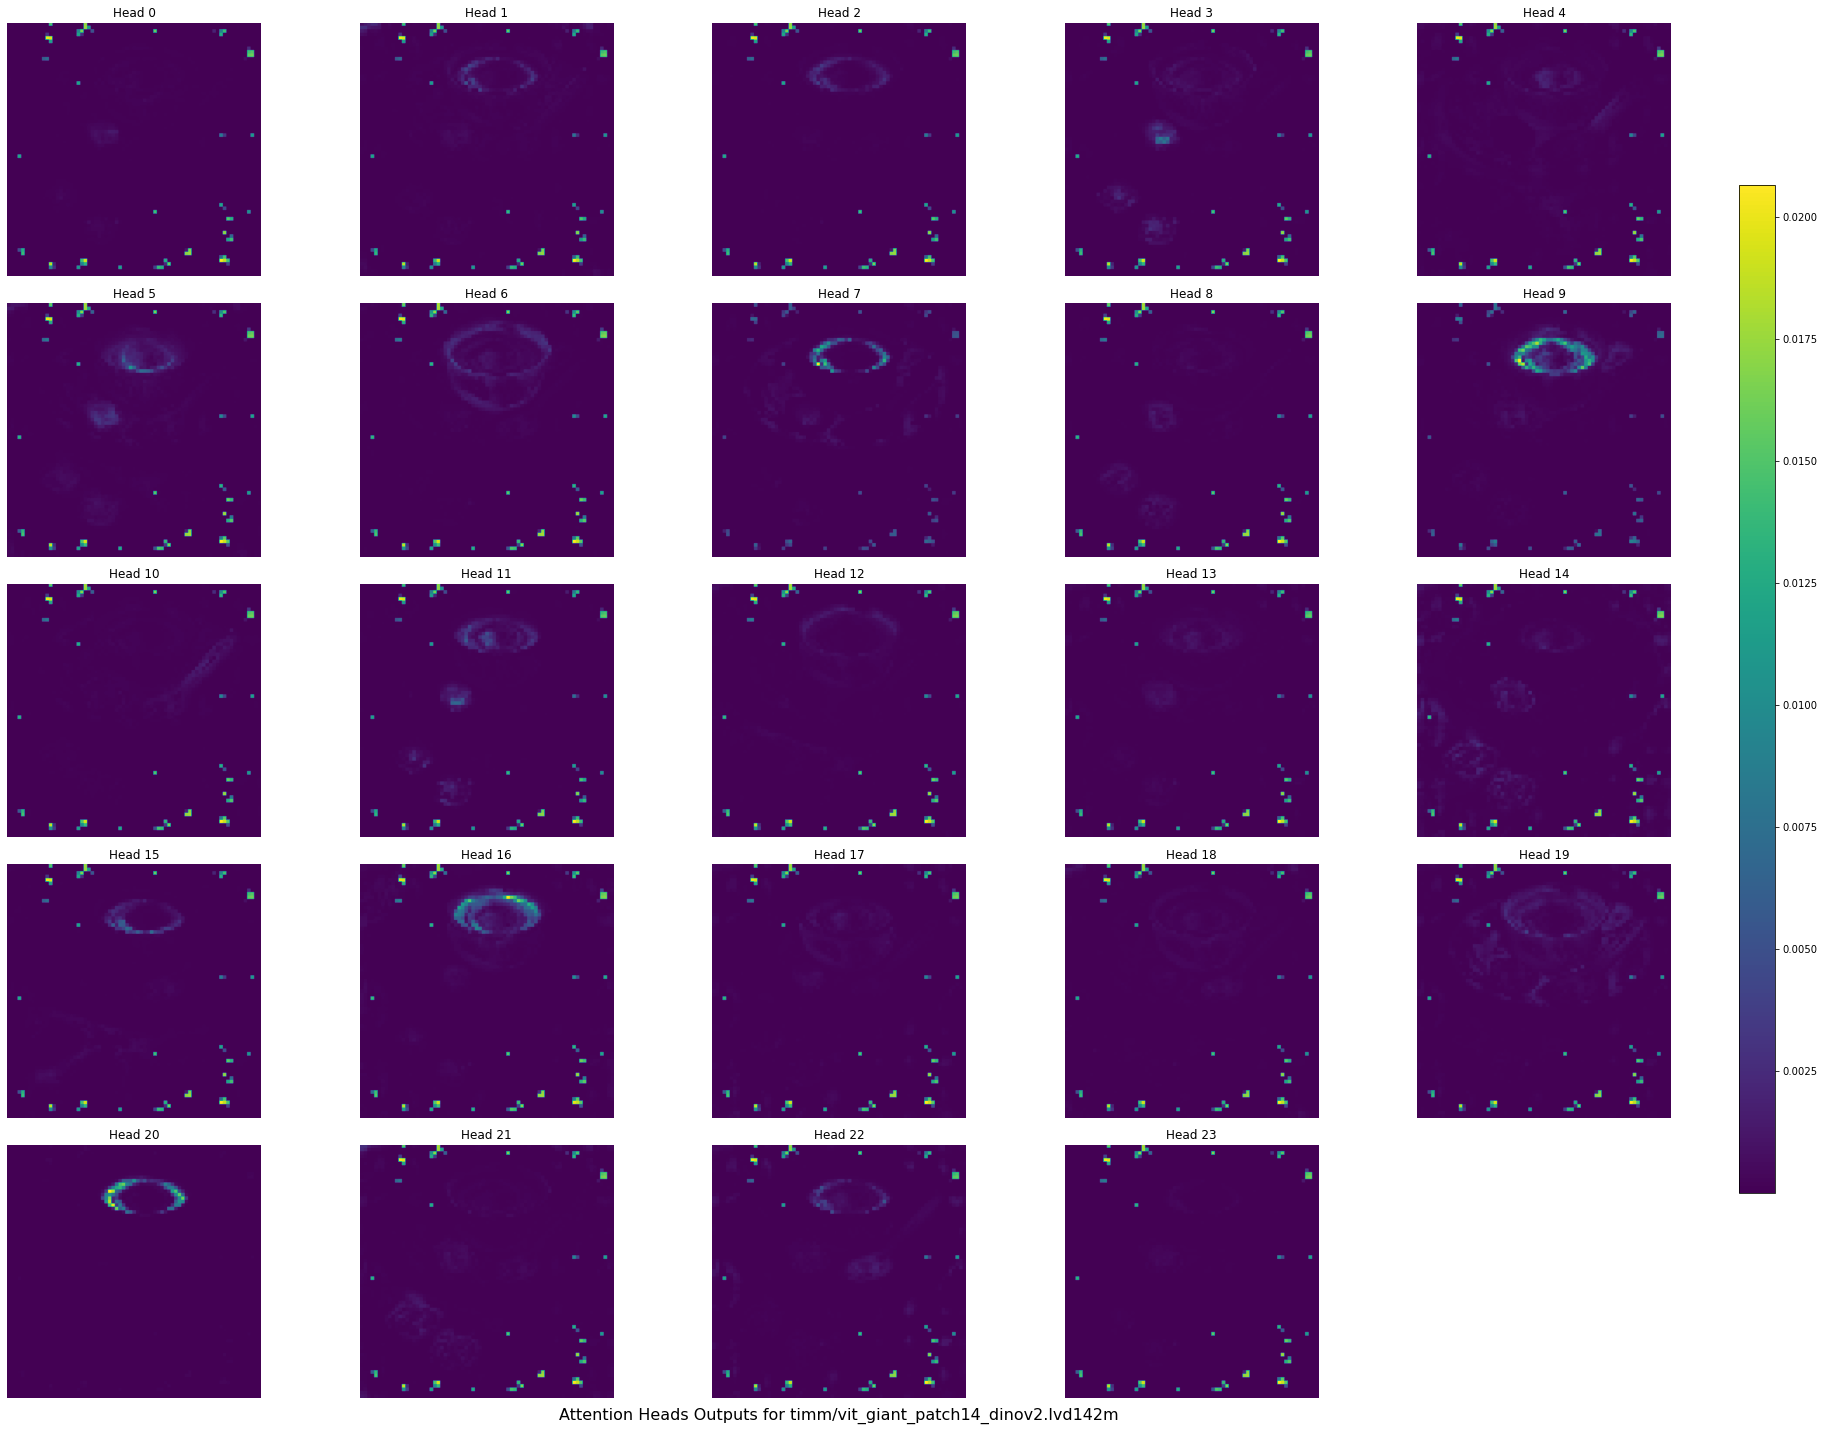

In [10]:
b, num_heads, num_patches_1, num_patches_1 = outputs["attention"].shape
map_size = int(np.sqrt(num_patches_1 - 1))

num_plots = num_heads
cols = int(np.ceil(np.sqrt(num_plots)))
rows = int(np.ceil(num_plots / cols))

fig, axes = plt.subplots(rows, cols, figsize=(25, 20))
axes = axes.flatten()

for i in range(num_plots):
    attention_head = i
    attention_map = outputs["attention"][:, attention_head, 0, 1:]
    attention_map = attention_map.view(1, 1, map_size, map_size)
    attention_map = nn.Upsample(size=(img_size, img_size))(attention_map)
    attention_map = attention_map[0, 0, :, :].detach().cpu().numpy()

    im = axes[i].imshow(attention_map)
    axes[i].set_title(f'Head {attention_head}')
    axes[i].axis('off')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig.suptitle('Attention Heads Outputs for '+model_no_reg_path, y=0.001, fontsize=16)

plt.tight_layout()
plt.show()